In [ ]:
import pandas as pd
import numpy as np
import json
import h5py
import torch as pt
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import seaborn as sns
from statistics import median
from scipy import stats
import metapredict as meta
from Bio.PDB import PDBParser, DSSP

In [2]:
def get_dssp(pdb_filename):
    parser = PDBParser()
    structure = parser.get_structure('PDB', pdb_filename)
    model = structure[0]
    dssp = DSSP(model, pdb_filename, dssp='mkdssp')
    ss = []
    seq = ''
    for residue in dssp:
        seq += residue[1]  # Add amino acid to sequence
        ss.append(residue[2])  # Add secondary structure to list
    ss = ''.join(ss)
    
    return seq, ss

In [3]:
b53 = '/home/omokhtar/Desktop/final_atom/data/benchmarks/MaSIF/predictions_af_307.json'
b60_nody = '/home/omokhtar/Desktop/final_atom/data/benchmarks/equippis/predictions_af_308.json'
b60 = '/home/omokhtar/Desktop/final_atom/data/benchmarks/equippis/predictions_af_307.json'
b53_nody = '/home/omokhtar/Desktop/final_atom/data/benchmarks/MaSIF/predictions_af_308.json'

b53, b60_nody, b60, b53_nody = [json.load(open(path, 'r')) for path in [b53, b60_nody, b60, b53_nody]]

b60_median = np.nanmedian([v[2][6] for v in b60.values()])
b60_median_pr = np.nanmedian([v[2][8] for v in b60.values()])
b53_median = np.nanmedian([v[2][6] for v in b53.values()])

In [129]:
# Taken from apply_PeSTo_model jupyter
PeSTo_auc = [ 0.9820747375488281, 0.8655789494514465, 0.9088626503944397, 0.988070547580719, 0.8595605492591858, 0.729529619216919, 0.8555220365524292, 0.932812511920929, 0.8906896710395813, 0.7162952423095703, 0.8545309901237488, 0.81409752368927, 0.8393750190734863, 0.5910776257514954, 0.8383738994598389, 0.9247331619262695, 0.972842812538147, 0.9766187071800232, 0.7412217259407043, 0.9342710971832275, 0.9805610179901123, 0.7579848170280457, 0.9479190707206726, 0.9959572553634644, 0.979884684085846, 0.5601250529289246, 0.6564126014709473, 0.8207474946975708, 0.8890202045440674, 0.6212064623832703, 0.806316077709198, 0.7470372915267944, 0.8291925191879272, 0.9061019420623779, 0.5505714416503906, 0.7071413397789001, 0.9486343264579773, 0.6108465790748596, 0.985808789730072, 0.9604193568229675, 0.7725352048873901, 0.7680143713951111, 0.3800143301486969, 0.4750633239746094, 0.9219721555709839, 0.9784629940986633, 0.8507142663002014, 0.8680188059806824, 0.9948326945304871, 0.9927366971969604, 0.6987179517745972, 0.828906238079071, 0.9057464003562927]
np.nanmedian(PeSTo_auc)

0.8555220365524292

## General Comparison - Barplots

In [109]:
# Prepare the data
transient_data = pd.DataFrame({
    'Method': ['DynamicGT-Bound', 'PeSTo', 'DynamicGT-AlphaFlow', 'MaSIF-site', 'SPPIDER'],
    'ROC-AUC': [0.868, np.nanmedian(PeSTo_auc), b53_median, 0.830, 0.650]
})

test60_data = pd.DataFrame({
    'Method': ['DynamicGT-AlphaFlow', 'EquiPPIS', 'GraphPPIS', 'MaSIF-site', 'SPPIDER'],
    'ROC-AUC': [b60_median, 0.805, 0.786, 0.775, 0.755],
    'PR-AUC': [b60_median_pr, 0.467, 0.429, 0.439, 0.373]
})

/tmp/ipykernel_17060/1436583554.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars1 = sns.barplot(


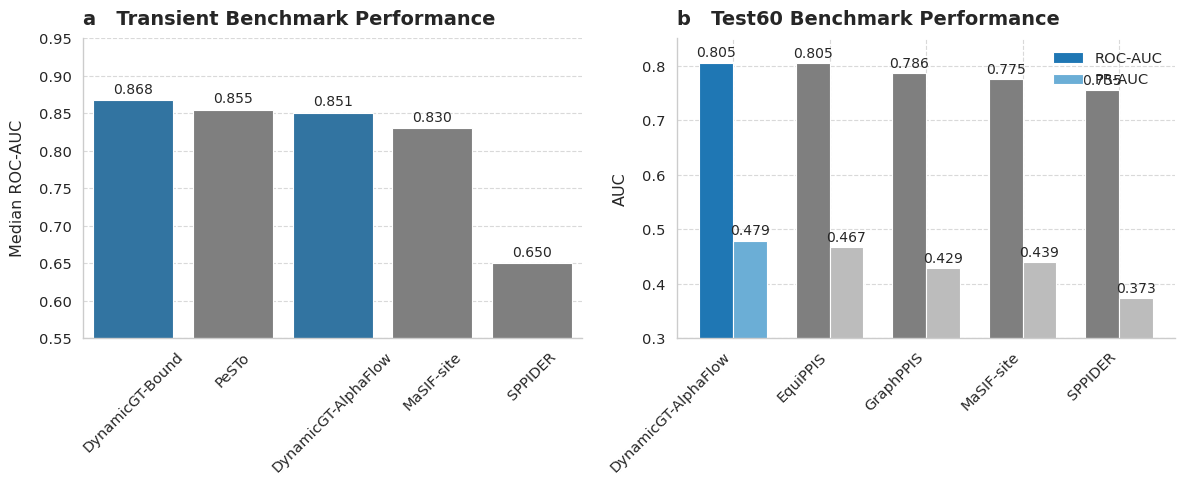

In [110]:
# 1. Define a color palette
main_color = '#1f77b4'  # Blue for DynamicGT
other_color = '#7f7f7f'  # Gray for other methods
lighter_main_color = '#6baed6'  # Lighter blue
lighter_other_color = '#bcbcbc'  # Lighter gray

colors_transient = [
    main_color if 'DynamicGT' in method else other_color
    for method in transient_data['Method']
]

# We’ll pair the same color families for ROC-AUC and PR-AUC or test60:
roc_colors = [
    main_color if 'DynamicGT' in m else other_color 
    for m in test60_data['Method']
]
pr_colors = [
    lighter_main_color if 'DynamicGT' in m else lighter_other_color
    for m in test60_data['Method']
]

sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.2)

sns.set_style({
    "axes.facecolor": "white",
    "grid.color": "0.85",
    "grid.linestyle": "--"
})

# Create two subplots
fig, (ax1, ax2) = plt.subplots(
    1, 2, 
    figsize=(12, 5),
    sharey=False
)

# 3. Plot 1: Transient Benchmark
bars1 = sns.barplot(
    data=transient_data, 
    x='Method', 
    y='ROC-AUC',
    palette=colors_transient,
    ax=ax1
)

for i, bar in enumerate(bars1.patches):
    ax1.text(
        bar.get_x() + bar.get_width()/2., 
        bar.get_height()+0.005,
        f'{transient_data["ROC-AUC"].iloc[i]:.3f}',
        ha='center', 
        va='bottom',
        fontsize=10
    )

ax1.set_title('a   Transient Benchmark Performance', 
              loc='left', 
              fontsize=14, 
              fontweight='bold', 
              pad=10)
ax1.set_xlabel('')
ax1.set_ylabel('Median ROC-AUC', labelpad=10)
ax1.set_ylim(0.55, 0.95) 
ax1.tick_params(axis='x', rotation=45)

sns.despine(ax=ax1, top=True, right=True)

# 4. Plot 2: Test60 Benchmark
width = 0.35
x = np.arange(len(test60_data))

roc_bars = ax2.bar(
    x - width/2, 
    test60_data['ROC-AUC'], 
    width, 
    label='ROC-AUC',
    color=roc_colors
)
pr_bars = ax2.bar(
    x + width/2, 
    test60_data['PR-AUC'], 
    width, 
    label='PR-AUC',
    color=pr_colors
)

for i, (roc_bar, pr_bar) in enumerate(zip(roc_bars, pr_bars)):
    ax2.text(
        roc_bar.get_x() + roc_bar.get_width()/2., 
        roc_bar.get_height()+0.005, 
        f'{test60_data["ROC-AUC"].iloc[i]:.3f}',
        ha='center', 
        va='bottom', 
        fontsize=10
    )
    ax2.text(
        pr_bar.get_x() + pr_bar.get_width()/2., 
        pr_bar.get_height()+0.005, 
        f'{test60_data["PR-AUC"].iloc[i]:.3f}',
        ha='center', 
        va='bottom', 
        fontsize=10
    )

ax2.set_title('b   Test60 Benchmark Performance', 
              loc='left', 
              fontsize=14, 
              fontweight='bold', 
              pad=10)
ax2.set_xticks(x)
ax2.set_xticklabels(test60_data['Method'], rotation=45, ha='right')
ax2.set_xlabel('')
ax2.set_ylabel('AUC', labelpad=10)
ax2.set_ylim(0.3, 0.85)

ax2.legend(loc='upper right', frameon=False)

sns.despine(ax=ax2, top=True, right=True)

plt.tight_layout()

plt.savefig('general_benchmark_comparison.svg', dpi=600, bbox_inches='tight', format = 'svg', transparent = True)

plt.show()

## Dynamic Vs. No Dynamic - Curve line plot

In [115]:
r = h5py.File('/home/omokhtar/Desktop/PPI/data/db_benchmarks_with_dists.h5','r')

In [112]:
b53_medians = np.array([np.round(v[2][6][0],3) for v in b53.values()])
b53_nody_medians = np.array([np.round(v[2][6][0],3) for v in b53_nody.values()])

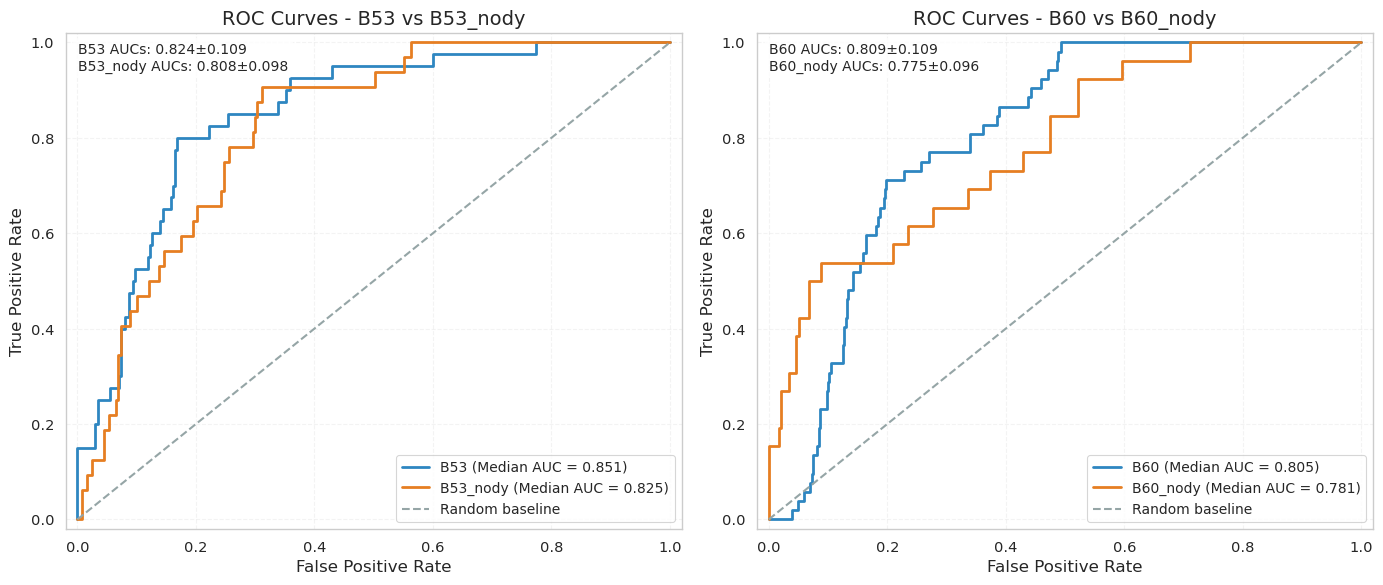

In [114]:
def calculate_per_protein_metrics(data_dict, r):
    protein_aucs = []
    protein_data = []
    
    for chain in data_dict:
        y = list(map(lambda a: int(a[0]), pt.from_numpy(np.array(r[f'data/labels/{chain}/label']))))
        p = np.array(data_dict[chain][0]).flatten()
        
        fpr, tpr, _ = roc_curve(y, p)
        roc_auc = auc(fpr, tpr)
        
        protein_aucs.append(roc_auc)
        protein_data.append((fpr, tpr, roc_auc))
    
    median_auc = median(protein_aucs)
    
    median_idx = min(range(len(protein_aucs)), 
                    key=lambda i: abs(protein_aucs[i] - median_auc))
    median_fpr, median_tpr, _ = protein_data[median_idx]
    
    return {
        'all_aucs': protein_aucs,
        'median_auc': median_auc,
        'median_fpr': median_fpr,
        'median_tpr': median_tpr
    }

def plot_model_comparisons(b53_dict, b53_nody_dict, b60_dict, b60_nody_dict, r, save_path=None):
    b53_metrics = calculate_per_protein_metrics(b53_dict, r)
    b53_nody_metrics = calculate_per_protein_metrics(b53_nody_dict, r)
    b60_metrics = calculate_per_protein_metrics(b60_dict, r)
    b60_nody_metrics = calculate_per_protein_metrics(b60_nody_dict, r)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    colors = ['#2E86C1', '#E67E22']  # Blue and Orange
    baseline_color = '#95A5A6'  # Gray
    
    # Plot B53 comparisons (ax1)
    ax1.plot(b53_metrics['median_fpr'], b53_metrics['median_tpr'], 
            color=colors[0], lw=2,
            label=f'B53 (Median AUC = {b53_metrics["median_auc"]:.3f})')
    
    ax1.plot(b53_nody_metrics['median_fpr'], b53_nody_metrics['median_tpr'], 
            color=colors[1], lw=2,
            label=f'B53_nody (Median AUC = {b53_nody_metrics["median_auc"]:.3f})')
    
    ax1.plot([0, 1], [0, 1], color=baseline_color, lw=1.5, linestyle='--',
            label='Random baseline')
    
    # Plot B60 comparisons (ax2)
    ax2.plot(b60_metrics['median_fpr'], b60_metrics['median_tpr'], 
            color=colors[0], lw=2,
            label=f'B60 (Median AUC = {b60_metrics["median_auc"]:.3f})')
    
    ax2.plot(b60_nody_metrics['median_fpr'], b60_nody_metrics['median_tpr'], 
            color=colors[1], lw=2,
            label=f'B60_nody (Median AUC = {b60_nody_metrics["median_auc"]:.3f})')
    
    ax2.plot([0, 1], [0, 1], color=baseline_color, lw=1.5, linestyle='--',
            label='Random baseline')
    
    for ax, title in [(ax1, 'B53 vs B53_nody'), (ax2, 'B60 vs B60_nody')]:
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('False Positive Rate', fontsize=12)
        ax.set_ylabel('True Positive Rate', fontsize=12)
        ax.set_title(f'ROC Curves - {title}', fontsize=14)
        ax.legend(loc='lower right', fontsize=10)
        ax.grid(True, alpha=0.3)
    
    for ax, metrics1, metrics2, label1, label2 in [
        (ax1, b53_metrics, b53_nody_metrics, 'B53', 'B53_nody'),
        (ax2, b60_metrics, b60_nody_metrics, 'B60', 'B60_nody')
    ]:
        stats_text = (f'{label1} AUCs: {np.mean(metrics1["all_aucs"]):.3f}±{np.std(metrics1["all_aucs"]):.3f}\n'
                     f'{label2} AUCs: {np.mean(metrics2["all_aucs"]):.3f}±{np.std(metrics2["all_aucs"]):.3f}')
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
                verticalalignment='top', fontsize=10,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=600, bbox_inches='tight', format = 'svg', transparent = True)
        
    return fig, (ax1, ax2)

fig, axes = plot_model_comparisons(b53, b53_nody, b60, b60_nody, r, 
                                 save_path='model_comparisons_median_curves.svg')
plt.show()

## Distance to IF - Joint plot

In [134]:
def merge_and_average(aa_map, ins):
    if len(aa_map) != len(ins):
        raise ValueError(f"{len(aa_map)},{len(ins)}--->Length of aa_map and ins must be the same")
    
    merged = {}
    for aa, value in zip(aa_map, ins):
        if aa not in merged:
            merged[aa] = []
        merged[aa].append(value)
    result = [sum(values) / len(values) for values in merged.values()]
    
    return result
    
ps=[]
dists=[]
rsas = []
r = h5py.File('/home/omokhtar/Desktop/PPI/data/db_benchmarks_with_dists2.h5','r')
for chain in b53:
    aa_map = list(r[f'data/features/{chain}/aa_map'])
    dist = list(map(lambda a:float(a),pt.from_numpy(np.array(r[f'data/labels/{chain}/dist']))))
    rsa = list(r[f'data/features/{chain}/rsa'])
    p = list(map(lambda a:a[0],b53[chain][0]))
    if len(set(dist))<2: continue
    ps.extend(p)
    dists.extend(dist)
    rsas.extend(merge_and_average(aa_map,[1 if i < 0.16 else 0 for i in rsa]))


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


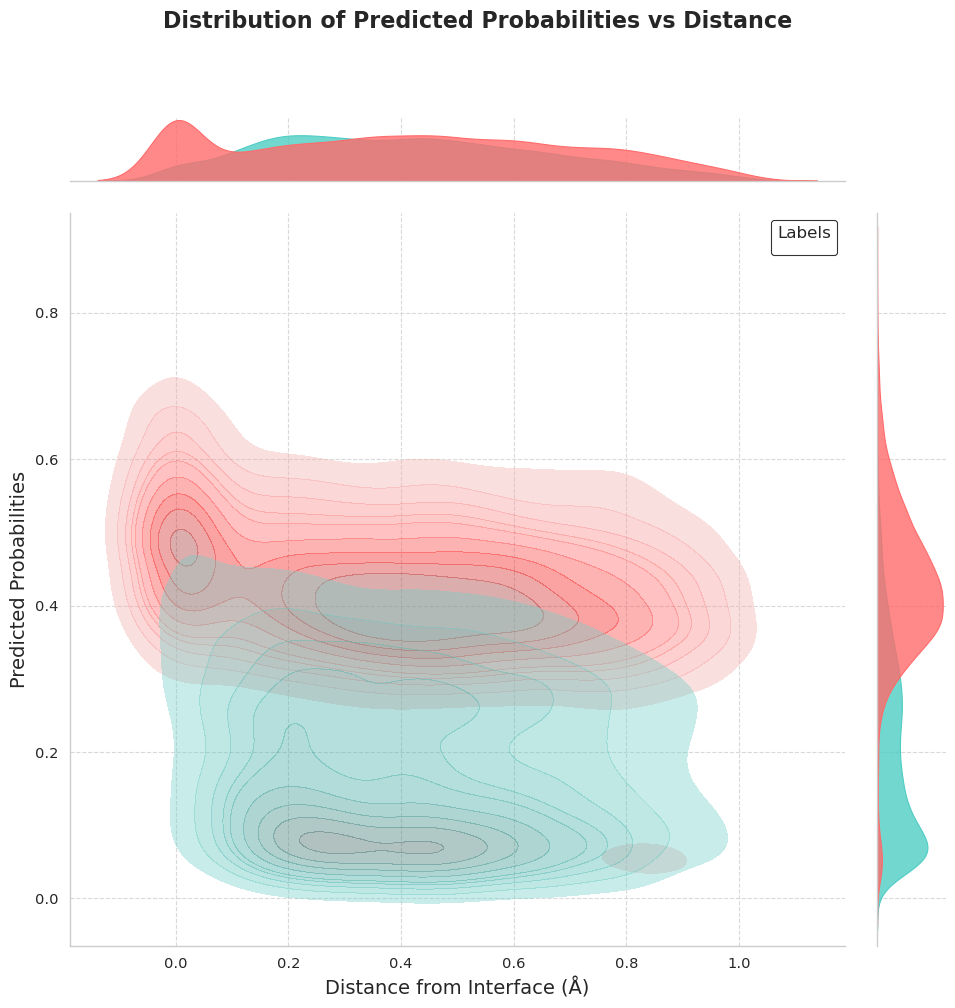

In [139]:
df = pd.DataFrame({'dists': list(dists), 'types': list(rsas), 'ps': list(ps)})

g = sns.jointplot(
    data=df,
    x="dists",
    y="ps",
    hue="types",
    kind="kde",
    height=10,
    ratio=8,
    marginal_kws=dict(fill=True, alpha=0.8), 
    joint_kws=dict(fill=True, alpha=0.4, thresh=0.1, levels=10),
    #palette=['#0072B2', '#D55E00'],
    palette=['#FF6B6B', '#4ECDC4']
)

g.fig.suptitle('Distribution of Predicted Probabilities vs Distance', 
               y=1.02, 
               fontsize=16, 
               fontweight='bold')

g.ax_joint.set_xlabel('Distance from Interface (Å)', fontsize=14)
g.ax_joint.set_ylabel('Predicted Probabilities', fontsize=14)
d
legend = g.ax_joint.legend(title='Labels',
                          title_fontsize=12,
                          fontsize=11,
                          loc='upper right',
                          frameon=True)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(0.8)

plt.tight_layout(pad=2)

g.savefig('joint_kde_plot.svg',
          format='svg',
          dpi=600,
          transparent=True,
          bbox_inches='tight',
          facecolor='white',
          edgecolor='none')

plt.show()

## Disorder

In [140]:
#p_to_bfactor(dic, device, '/home/omokhtar/Desktop/final_atom/data/benchmarks/MaSIF/predictions')

In [94]:
fuz_ss = '/home/omokhtar/Desktop/final_atom/data/benchmarks/FuzDB/0_fuzdb_ss.csv'
fuzdb_performance = '/home/omokhtar/Desktop/final_atom/data/benchmarks/FuzDB/predictions_af_307.json'
idr_performance = '/home/omokhtar/Desktop/final_atom/data/benchmarks/IDP/predictions_af_307.json'
idr_ss = '/home/omokhtar/Desktop/final_atom/data/benchmarks/IDP/data_IDRbind.csv'
fuzdb_performance_nody = '/home/omokhtar/Desktop/final_atom/data/benchmarks/FuzDB/predictions_af_308.json'
idr_performance_nody = '/home/omokhtar/Desktop/final_atom/data/benchmarks/IDP/predictions_af_308.json'

In [95]:
df = pd.read_csv(fuz_ss, delimiter=',')
df['acc'] = df['acc'].str[:4].str.upper() + df['acc'].str[4:]
ratios_FuzDB = {
    acc: (df[df['acc'] == acc]['ss'].values[0].count('S')+df[df['acc'] == acc]['ss'].values[0].count('T')+df[df['acc'] == acc]['ss'].values[0].count('-')) / len(df[df['acc'] == acc]['fasta'].values[0])
    for acc in df['acc'].unique()}  # Loop over all unique acc values

with open(fuzdb_performance, 'r') as json_file:
    results_FuzDB = json.load(json_file)
with open(fuzdb_performance_nody, 'r') as json_file:
    results_FuzDB_nody = json.load(json_file)

In [96]:
receptors=[]
disordered=[]
for each, value in ratios_FuzDB.items():
    if each not in results_FuzDB: continue
    if value>0.5:
        disordered.append(results_FuzDB[each][2][6][0])
    else:
        receptors.append(results_FuzDB[each][2][6][0])

In [97]:
print (f"{len(receptors)} receptors: {np.nanmedian(receptors)}")
print (f"{len(disordered)} disordered: {np.nanmedian(disordered)}")

21 receptors: 0.7966101765632629
77 disordered: 0.7686976492404938


In [98]:
df = pd.read_csv(idr_ss, delimiter=',')
df['acc'] = df['acc'].str[:4].str.upper() + df['acc'].str[4:]
ratios_IDRBind = {
    acc: (df[df['acc'] == acc]['ss'].values[0].count('S')+df[df['acc'] == acc]['ss'].values[0].count('T')+df[df['acc'] == acc]['ss'].values[0].count('-')) / len(df[df['acc'] == acc]['fasta'].values[0])
    for acc in df['acc'].unique()}  # Loop over all unique acc values

with open(idr_performance, 'r') as json_file:
    results_IDRBind = json.load(json_file)
with open(idr_performance_nody, 'r') as json_file:
    results_IDRBind_nody = json.load(json_file)

In [99]:
receptors=[]
disordered=[]
for each, value in ratios_IDRBind.items():
    if each not in results_IDRBind: continue
    if value>0.5:
        disordered.append(results_IDRBind[each][2][6][0])
    else:
        receptors.append(results_IDRBind[each][2][6][0])

In [100]:
print (f"{len(receptors)} receptors: {np.nanmedian(receptors)}")
print (f"{len(disordered)} disordered: {np.nanmedian(disordered)}")

42 receptors: 0.810648649930954
15 disordered: 0.7520080208778381


## combine FuzDB with IDRBind

In [181]:
do = {}
for each, value in ratios_IDRBind.items():
    if each not in results_IDRBind or len(results_IDRBind[each][1])<20: continue
    idrp_list = meta.predict_disorder(results_IDRBind_nody[each][1])
    idrp_percentage = (sum(i > 0.5 for i in idrp_list)/len(idrp_list))
    do[each] = [results_IDRBind_nody[each][2][6][0], results_IDRBind[each][2][6][0], idrp_percentage]
    
for each, value in ratios_FuzDB.items():
    if each not in results_FuzDB or len(results_FuzDB[each][1])<20: continue
    idrp_list = meta.predict_disorder(results_FuzDB_nody[each][1])
    idrp_percentage = (sum(i > 0.5 for i in idrp_list)/len(idrp_list))
    do[each] = [results_FuzDB_nody[each][2][6][0], results_FuzDB[each][2][6][0], idrp_percentage]

/home/omokhtar/anaconda3/envs/dl/lib/python3.10/site-packages/metapredict/backend/py_predictor_v2.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.l

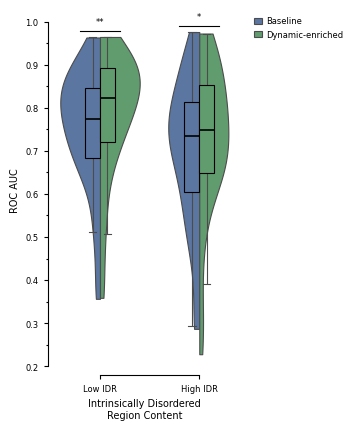

In [299]:
def create_publication_violin(data_dict, output_filename='model_comparison.svg'):
    plt.style.use('default')
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42
    
    sns.set_context("paper", font_scale=1.2, rc={
        "axes.linewidth": 0.8,
        "axes.labelsize": 7,
        "xtick.labelsize": 6,
        "ytick.labelsize": 6,
        "xtick.major.width": 0.8,
        "ytick.major.width": 0.8,
        "xtick.major.size": 3,
        "ytick.major.size": 3,
        "xtick.minor.width": 0.6,
        "ytick.minor.size": 1.5
    })

    df = pd.DataFrame([
        (k, v[0], v[1], v[2]) for k, v in data_dict.items()
        if all(isinstance(x, (int, float)) and np.isfinite(x) for x in v)
    ], columns=['protein_id', 'static_auc', 'dynamic_auc', 'unstructured_ratio'])
    
    median_ratio = df['unstructured_ratio'].median()
    df['group'] = df['unstructured_ratio'].apply(
        lambda x: 'High IDR' if x >= median_ratio else 'Low IDR'
    )
    
    df_melted = pd.melt(
        df,
        id_vars=['protein_id', 'group'],
        value_vars=['static_auc', 'dynamic_auc'],
        var_name='model',
        value_name='auc'
    )
    
    nature_colors = ['#4C72B0', '#55A868']
    df_melted['model'] = df_melted['model'].map({
        'static_auc': 'Baseline',
        'dynamic_auc': 'Dynamic-enriched'
    })
    
    width_inches = 89 / 25.4
    height_inches = width_inches * 1.2 
    fig, ax = plt.subplots(figsize=(width_inches, height_inches))
    
    sns.violinplot(
        data=df_melted,
        x='group',
        y='auc',
        hue='model',
        split=True,
        inner=None,
        palette=nature_colors,
        linewidth=0.8,
        saturation=0.7,
        cut=0,
        ax=ax
    )

    sns.boxplot(
        data=df_melted,
        x='group',
        y='auc',
        hue='model',
        palette=nature_colors,
        width=0.3,
        boxprops={'edgecolor': 'black', 'linewidth': 0.8, 'zorder': 3},
        medianprops={'color': 'black', 'linewidth': 1.2, 'zorder': 3},
        whiskerprops={'linewidth': 0.8},
        capprops={'linewidth': 0.8},
        showfliers=False,
        saturation=0.7,
        dodge=True,
        ax=ax
    )
    
    ax.legend_.remove()

    handles, labels = ax.get_legend_handles_labels()
    legend = ax.legend(
        handles[:2],
        labels[:2],
        title=None,
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        frameon=False,
        fontsize=6,
        handlelength=1,
        handletextpad=0.5,
        columnspacing=1
    )

    for i, group in enumerate(['Low IDR', 'High IDR']):
        group_data = df[df['group'] == group]
        stat, pval = stats.ttest_rel(group_data['dynamic_auc'], group_data['static_auc'])
        
        sig = ''
        if pval < 0.0001:
            sig = '****'
        elif pval < 0.001:
            sig = '***'
        elif pval < 0.01:
            sig = '**'
        elif pval < 0.05:
            sig = '*'
        else:
            sig = 'ns'
        
        y_max = df_melted[df_melted['group'] == group]['auc'].max()
        y_bar = y_max + 0.015
        plt.plot([i - 0.2, i + 0.2], [y_bar, y_bar], '-k', linewidth=0.8, zorder=4)
        plt.text(i, y_bar + 0.01, sig, ha='center', va='bottom', fontsize=6)
    
    plt.xlabel('Intrinsically Disordered\nRegion Content', fontsize=7, labelpad=4)
    plt.ylabel('ROC AUC', fontsize=7, labelpad=4)
    
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
    ax.yaxis.set_minor_locator(plt.MultipleLocator(0.05))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
    
    sns.despine(offset=3, trim=True)
    plt.tight_layout(pad=0.3)
    
    plt.savefig(
        output_filename,
        dpi=1000,
        bbox_inches='tight',
        format='svg',
        transparent=True
    )
    plt.show()
    
    return df_melted
df_violin = create_publication_violin(do)

In [285]:
r = h5py.File('/home/omokhtar/Desktop/PPI/data/db_benchmarks_with_dists.h5','r')

merged_results = results_FuzDB.copy()
merged_results.update(results_IDRBind)

merged_df = pd.concat([pd.read_csv(fuz_ss, delimiter=','), pd.read_csv(idr_ss, delimiter=',')], ignore_index=True)

In [287]:
dic3={}
for each in merged_results:
    if each in merged_df['acc'].values:
        dic3[each] = [list(map(lambda x:float(x[0]), merged_results[each][0]))] + [merged_df.loc[merged_df['acc'] == each, 'ss'].values[0]]
        dic3[each].append(list(map(lambda x:int(x[0]),list(r['data/labels'][each]['label']))))

In [291]:
data = {'label': [entry[2] for entry in dic3.values()],
        'pred_prob': [entry[0] for entry in dic3.values()],
        'structure_status': [entry[1] for entry in dic3.values()]}

df = pd.DataFrame(data)

expanded_data = []
for idx, row in df.iterrows():
    for label, prob, status in zip(row['label'], row['pred_prob'], row['structure_status']):
        if status == 'S' or status == 'T' or status == '-':
            group = 'Unstructured'
        else:
            group = 'Structured'
        expanded_data.append({'label': label, 'pred_prob': prob, 'structure_group': group})

expanded_df = pd.DataFrame(expanded_data)
expanded_df['pred_label'] = (expanded_df['pred_prob'] > 0.5).astype(int)

expanded_df

,label,pred_prob,structure_group,pred_label
0,0,0.690075,Unstructured,1
1,0,0.838351,Unstructured,1
2,0,0.791151,Unstructured,1
3,1,0.819622,Unstructured,1
4,1,0.836673,Unstructured,1
...,...,...,...,...
11390,1,0.684941,Structured,1
11391,1,0.636406,Structured,1
11392,0,0.471277,Unstructured,0
11393,1,0.662949,Unstructured,1


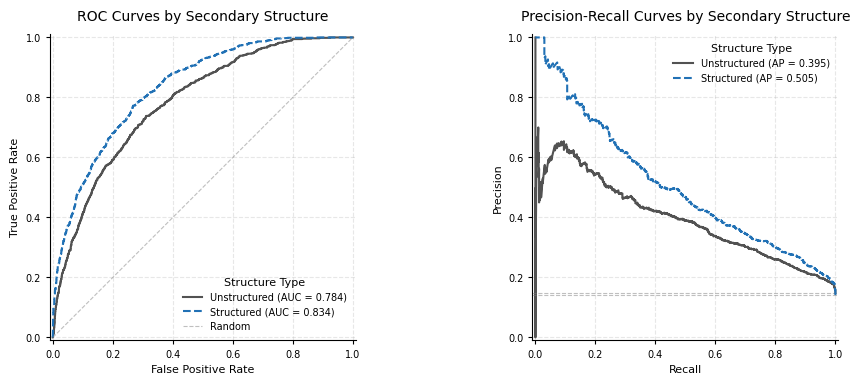

In [296]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

colors = {'Unstructured': '#525252', 'Structured': '#2171b5'}
linestyles = {'Unstructured': '-', 'Structured': '--'}

for structure in ['Unstructured','Structured']:
    mask = expanded_df['structure_group'] == structure
    y_true = expanded_df[mask]['label']
    y_score = expanded_df[mask]['pred_prob']
    
    baseline = np.sum(y_true) / len(y_true)
    
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    
    ax1.plot(fpr, tpr, 
             label=f'{structure} (AUC = {roc_auc:.3f})',
             color=colors[structure],
             linestyle=linestyles[structure],
             linewidth=1.5)

    precision, recall, _ = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)
    
    ax2.plot(recall, precision,
             label=f'{structure} (AP = {ap:.3f})',
             color=colors[structure],
             linestyle=linestyles[structure],
             linewidth=1.5)
    
    ax2.axhline(y=baseline, color='gray', linestyle='--', 
                linewidth=0.8, alpha=0.5)

ax1.plot([0, 1], [0, 1], color='gray', linestyle='--', 
         linewidth=0.8, alpha=0.5, label='Random')
ax1.set_xlabel('False Positive Rate', fontsize=8)
ax1.set_ylabel('True Positive Rate', fontsize=8)
ax1.set_title('ROC Curves by Secondary Structure', fontsize=10, pad=10)
ax1.set_xlim(-0.01, 1.01)
ax1.set_ylim(-0.01, 1.01)
ax1.set_aspect('equal')
ax1.tick_params(axis='both', labelsize=7)
ax1.grid(True, linestyle='--', alpha=0.3)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax2.set_xlabel('Recall', fontsize=8)
ax2.set_ylabel('Precision', fontsize=8)
ax2.set_title('Precision-Recall Curves by Secondary Structure', fontsize=10, pad=10)
ax2.set_xlim(-0.01, 1.01)
ax2.set_ylim(-0.01, 1.01)
ax2.set_aspect('equal')
ax2.tick_params(axis='both', labelsize=7)
ax2.grid(True, linestyle='--', alpha=0.3)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

ax1.legend(title='Structure Type',
          fontsize=7,
          title_fontsize=8,
          frameon=False,
          loc='lower right')

ax2.legend(title='Structure Type',
          fontsize=7,
          title_fontsize=8,
          frameon=False,
          loc='upper right')

plt.tight_layout()

plt.savefig('disorder_ss.svg', dpi=600, bbox_inches='tight', format='svg', transparent=True)

### Other Way Around

In [256]:
unique_ids = {}
for key in ratios_FuzDB:
    id_part, chain = key.split('_')
    ratio = ratios_FuzDB[key]
    
    if id_part in unique_ids:
        unique_ids[id_part][chain] = ratio
    else:
        unique_ids[id_part] = {chain: ratio}
for key in ratios_IDRBind:
    id_part, chain = key.split('_')
    ratio = ratios_IDRBind[key]
    
    if id_part in unique_ids:
        unique_ids[id_part][chain] = ratio
    else:
        unique_ids[id_part] = {chain: ratio}
unique_ids

{'1A0N': {'A': 1.0, 'B': 0.46551724137931033},
 '1ABT': {'A': 0.7027027027027027, 'B': 1.0},
 '1AFO': {'A': 0.325, 'B': 0.325},
 '1AH1': {'A': 0.6046511627906976},
 '1AJY': {'A': 0.5211267605633803, 'B': 0.5211267605633803},
 '1AOU': {'F': 0.5566037735849056, 'P': 1.0},
 '1AZE': {'A': 0.5535714285714286, 'B': 1.0},
 '1B8Q': {'A': 0.6771653543307087, 'B': 1.0},
 '1BON': {'A': 0.8, 'B': 0.6785714285714286},
 '1BXP': {'A': 0.7702702702702703, 'B': 1.0},
 '1CEE': {'A': 0.4301675977653631, 'B': 0.8813559322033898},
 '1CSY': {'A': 0.6607142857142857, 'B': 1.0},
 '1DIP': {'A': 0.5974025974025974, 'B': 0.5324675324675324},
 '1DPU': {'A': 0.4057971014492754, 'B': 0.375},
 '1DWL': {'A': 0.559322033898305, 'B': 0.5569620253164557},
 '1EES': {'A': 0.6292134831460674, 'B': 0.9130434782608695},
 '1EJQ': {'A': 1.0, 'B': 1.0},
 '1EJY': {'N': 1.0, 'I': 0.2699530516431925},
 '1EYG': {'A': 0.41964285714285715,
  'B': 0.3557692307692308,
  'C': 0.4017857142857143,
  'D': 0.44642857142857145},
 '1G0V': {'A

In [269]:
receptor_s = []
receptor_us = []
for id_part, chains in unique_ids.items():
    ratios = list(chains.values())
    max_ratio = max(ratios)
    min_ratio = min(ratios)
    
    chains_with_max = [chain for chain, ratio in chains.items() if ratio == max_ratio]
    chains_with_min = [chain for chain, ratio in chains.items() if ratio == min_ratio]
    if max_ratio > 0.5 and min_ratio < 0.5:
        for chain in chains_with_min:
            receptor_us.append(id_part+'_'+chain)
    elif max_ratio < 0.5 and min_ratio < 0.5:
        for chain in chains_with_min:
            receptor_s.append(id_part+'_'+chain)

print(f"Receptor_S: {len(receptor_s)}")
print(f"Receptor_US: {len(receptor_us)}")

Receptor_S: 162
Receptor_US: 148


In [280]:
receptor_s_performance = []
receptor_us_performance = []

for each in receptor_s:
    if each in merged_results:
        print (each,merged_results[each][2][6][0])
        receptor_s_performance.append(merged_results[each][2][6][0])
print ()
for each in receptor_us:
    if each in merged_results:
        print (each,merged_results[each][2][6][0])
        receptor_us_performance.append(merged_results[each][2][6][0])
print(f"Receptor_S_Performance: {len(receptor_s_performance)}")
print(f"Receptor_US_Performance: {len(receptor_us_performance)}")

1DPU_B 0.682539701461792
1P23_A 0.9166666865348816
1ZY3_B 0.9722222089767456
2K2F_D 0.5625
2M0B_A 0.6354166865348816
2MKR_B 0.6428571343421936
4BXU_B 0.9642857313156128
6NHW_A 0.800000011920929
3SI5_A 0.8533674478530884

1CEE_A 0.7312925457954407
1M0V_A 0.3898181915283203
1OZS_A 0.9402298927307129
2K2U_A 0.773755669593811
2KTB_B 0.8382936716079712
2LKM_B 0.8815432786941528
2LOB_A 0.8893229365348816
2LTO_A 0.7207547426223755
2PHE_A 0.7693169116973877
2PHG_A 0.5555868148803711
2RVB_B 0.3588205873966217
4BD3_A 0.8292682766914368
5NWM_A 0.8534107208251953
6F0Y_A 0.7581374049186707
2QTV_A 0.807074248790741
3B71_A 0.6708144545555115
1DEV_A 0.6996430158615112
1G1S_B 0.6249433159828186
1SQK_A 0.9130434989929199
1M5N_S 0.8705960512161255
3AVR_A 0.6709027290344238
2KC8_A 0.7732007503509521
2LB2_A 0.9431818127632141
4FWF_A 0.6347615122795105
2X4W_A 0.9033247828483582
1G3J_A 0.7827029824256897
4JXT_A 0.9174938201904297
2LP0_A 0.49925926327705383
1TBA_B 0.9639037251472473
1QSN_A 0.7854238152503967


/tmp/ipykernel_7170/2326338904.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='Performance', data=data, palette="Set2", width=0.6, fliersize=5)


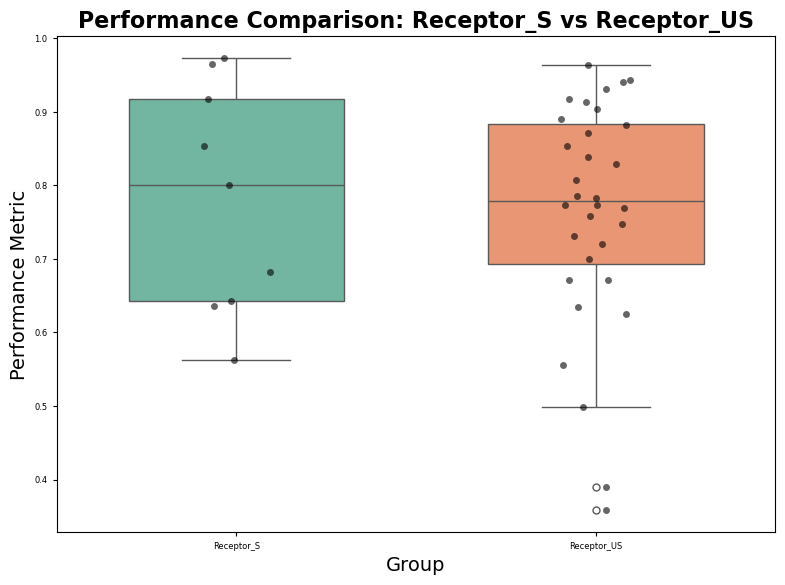

In [272]:
data = pd.DataFrame({
    'Performance': np.concatenate([receptor_s_performance, receptor_us_performance]),
    'Group': ['Receptor_S'] * len(receptor_s_performance) + ['Receptor_US'] * len(receptor_us_performance)
})

plt.figure(figsize=(8, 6))  # Adjust the figure size as needed

sns.boxplot(x='Group', y='Performance', data=data, palette="Set2", width=0.6, fliersize=5)

sns.stripplot(x='Group', y='Performance', data=data, color='black', size=5, jitter=True, alpha=0.6)


plt.title('Performance Comparison: Receptor_S vs Receptor_US', fontsize=16, weight='bold')
plt.xlabel('Group', fontsize=14)
plt.ylabel('Performance Metric', fontsize=14)

plt.tight_layout()

plt.show()

## RMSD Study

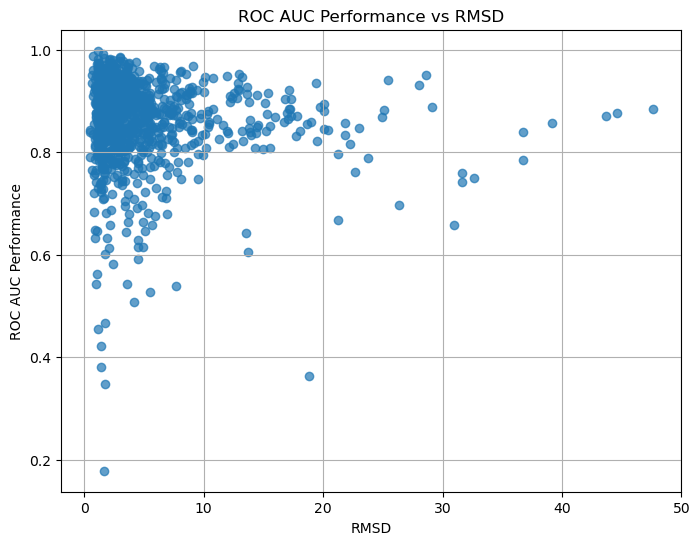

In [3]:
import json
import matplotlib.pyplot as plt

rmsd_file = "/home/omokhtar/Desktop/alphaflow/output/benchmarks_rmsd.txt"
fuzdb_performance = "/home/omokhtar/Desktop/final_atom/data/benchmarks/MFIB/predictions_af_307.json"

rmsd_data = {}
with open(rmsd_file, "r") as file:
    next(file)  # Skip header
    for line in file:
        parts = line.strip().split()
        if len(parts) == 3:
            pdbid_chainid, _, rmsd = parts
            rmsd_data[pdbid_chainid] = float(rmsd)

with open(fuzdb_performance, "r") as json_file:
    results_FuzDB = json.load(json_file)

roc_auc_values = []
rmsd_values = []

for pdbid_chainid, rmsd in rmsd_data.items():
    if pdbid_chainid in results_FuzDB:
        roc_auc = results_FuzDB[pdbid_chainid][2][6][0]  # Extracting the ROC AUC performance
        roc_auc_values.append(roc_auc)
        rmsd_values.append(rmsd)

plt.figure(figsize=(8, 6))
plt.scatter(rmsd_values, roc_auc_values, alpha=0.7)
plt.xlabel("RMSD")
plt.ylabel("ROC AUC Performance")
plt.title("ROC AUC Performance vs RMSD")
plt.grid(True)
plt.show()

3VP8_A 5.274839401245117 0.8703969120979309
2Q8V_B 5.258187294006348 0.8010100722312927
7VW2_A 5.970859050750732 0.9366071224212646
3B0C_T 4.899349689483643 0.9090612530708313
4J8C_B 6.8023834228515625 0.7788461446762085
8COK_B 5.539944648742676 0.8401083946228027
4GR2_A 5.446407794952393 0.9443589448928833
3ONX_B 5.221759796142578 0.8690032958984375
2GIB_A 4.351310729980469 0.9118773937225342
2JV7_B 4.4817047119140625 0.7796052694320679
3VW9_B 4.586148738861084 0.8128756284713745
2V0X_B 7.020992755889893 0.8257505893707275
1KU9_A 5.837098598480225 0.9674988985061646
1D9G_B 6.810388565063477 0.8842952251434326
2PJW_H 4.785217761993408 0.8056979775428772
3G6B_A 6.660663604736328 0.9652581214904785
1UNA_B 5.005396366119385 0.9021739363670349
2GE7_A 5.447883605957031 0.889082670211792
6QQS_A 7.0657267570495605 0.8719668984413147
7WAR_A 4.027358055114746 0.8933333158493042
7O9D_A 6.497274875640869 0.8554694652557373
7UX8_B 4.5591721534729 0.9299319982528687
3CRA_A 5.566450119018555 0.89534

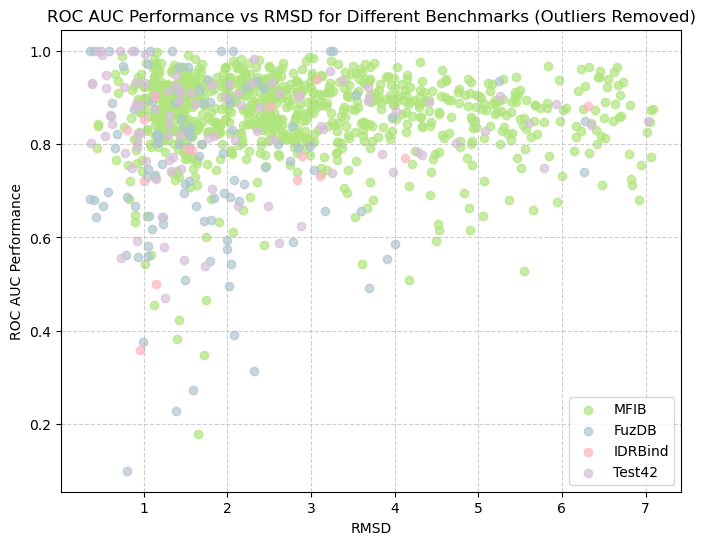

In [4]:
benchmark_files = {
    "MFIB": "/home/omokhtar/Desktop/final_atom/data/benchmarks/MFIB/predictions_af_307.json",
    "FuzDB": "/home/omokhtar/Desktop/final_atom/data/benchmarks/FuzDB/predictions_af_307.json",
    "IDRBind": "/home/omokhtar/Desktop/final_atom/data/benchmarks/IDP/predictions_af_307.json",
    "Test42": "/home/omokhtar/Desktop/final_atom/data/benchmarks/Bret_42/predictions_af_307.json",
}
benchmark_colors = {
    "FuzDB": "#AEC6CF",  # Pastel blue
    "IDRBind": "#FFB6C1",  # Pastel pink
    "MFIB": "#B0E57C",  # Pastel green
    "Test42": "#D8BFD8",  # Pastel purple
}
merged_list= [[],[],[]]
# Define function to remove RMSD outliers (Using IQR method)
def remove_outliers(data):
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return [x for x in data if lower_bound <= x <= upper_bound]

rmsd_values_raw = list(rmsd_data.values())
filtered_rmsd_values = remove_outliers(rmsd_values_raw)

plt.figure(figsize=(8, 6))

for benchmark_name, file_path in benchmark_files.items():
    with open(file_path, "r") as json_file:
        results = json.load(json_file)

    roc_auc_values = []
    rmsd_values = []

    for pdbid_chainid, rmsd in rmsd_data.items():
        if pdbid_chainid in results and rmsd in filtered_rmsd_values:
            roc_auc = results[pdbid_chainid][2][6][0]  # Extracting ROC AUC performance
            if roc_auc>0.75 and rmsd>4:
                print (pdbid_chainid, rmsd, roc_auc)
            roc_auc_values.append(roc_auc)
            rmsd_values.append(rmsd)

    merged_list[0].extend(rmsd_values)
    merged_list[1].extend(roc_auc_values)
    merged_list[2].extend(benchmark_name)
    plt.scatter(rmsd_values, roc_auc_values, alpha=0.7, label=benchmark_name, color=benchmark_colors[benchmark_name])

plt.xlabel("RMSD")
plt.ylabel("ROC AUC Performance")
plt.title("ROC AUC Performance vs RMSD for Different Benchmarks (Outliers Removed)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
#plt.savefig('IDR_RMSD2.svg', dpi=600,format='svg',transparent=True)
plt.show()


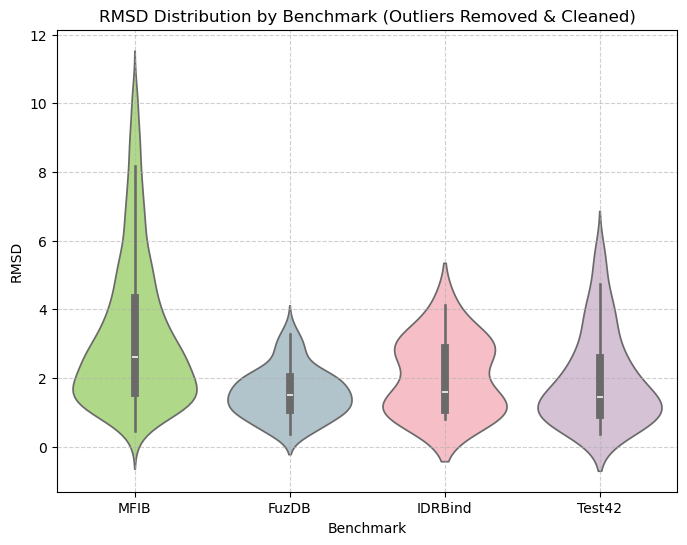

In [4]:
benchmark_rmsd = {name: [] for name in benchmark_files.keys()}

for benchmark_name, file_path in benchmark_files.items():
    with open(file_path, "r") as json_file:
        results = json.load(json_file)

    for pdbid_chainid, rmsd in rmsd_data.items():
        if pdbid_chainid in results:
            benchmark_rmsd[benchmark_name].append(rmsd)

filtered_benchmark_rmsd = {name: remove_outliers(values) for name, values in benchmark_rmsd.items()}

filtered_benchmark_rmsd_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in filtered_benchmark_rmsd.items()]))

plt.figure(figsize=(8, 6))
sns.violinplot(data=filtered_benchmark_rmsd_df, palette=benchmark_colors)
plt.xlabel("Benchmark")
plt.ylabel("RMSD")
plt.title("RMSD Distribution by Benchmark (Outliers Removed & Cleaned)")
plt.grid(True, linestyle="--", alpha=0.6)
#plt.savefig('IDR_RMSD.svg', dpi=600,format='svg',transparent=True)
plt.show()


In [15]:
if len(cleaned_rmsd) > 1 and len(cleaned_roc_auc) > 1:
    correlation, p_value = stats.pearsonr(cleaned_rmsd, cleaned_roc_auc)
    slope, intercept, r_value, p_value_reg, std_err = stats.linregress(cleaned_rmsd, cleaned_roc_auc)

    print("\n--- Cleaned RMSD vs ROC AUC Statistical Analysis ---")
    print(f"Pearson Correlation: {correlation:.4f}")
    print(f"P-Value (Correlation): {p_value:.4e}")
    print(f"Linear Regression Slope: {slope:.4f}")
    print(f"Linear Regression Intercept: {intercept:.4f}")
    print(f"R-Squared (Regression): {r_value**2:.4f}")
    print(f"P-Value (Regression): {p_value_reg:.4e}")
    print(f"Standard Error: {std_err:.4f}")
else:
    print("Not enough valid data points for statistical analysis.")



--- Cleaned RMSD vs ROC AUC Statistical Analysis ---
Pearson Correlation: 0.0022
P-Value (Correlation): 9.3839e-01
Linear Regression Slope: 0.0000
Linear Regression Intercept: 0.8479
R-Squared (Regression): 0.0000
P-Value (Regression): 9.3839e-01
Standard Error: 0.0006


/tmp/ipykernel_27071/2051328961.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Benchmark', y='RMSD', data=df, palette=benchmark_colors, linewidth=1, ax=axes[1])


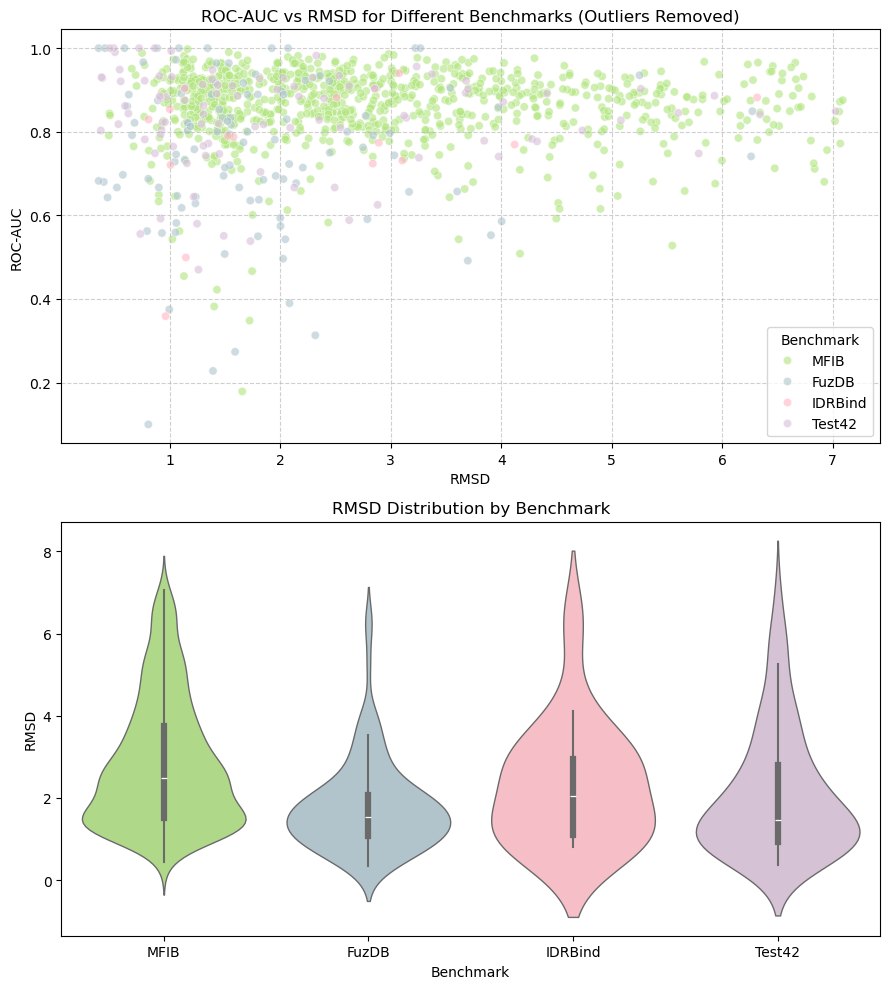

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json

# Benchmark file paths
benchmark_files = {
    "MFIB": "/home/omokhtar/Desktop/final_atom/data/benchmarks/MFIB/predictions_af_307.json",
    "FuzDB": "/home/omokhtar/Desktop/final_atom/data/benchmarks/FuzDB/predictions_af_307.json",
    "IDRBind": "/home/omokhtar/Desktop/final_atom/data/benchmarks/IDP/predictions_af_307.json",
    "Test42": "/home/omokhtar/Desktop/final_atom/data/benchmarks/Bret_42/predictions_af_307.json",
}
benchmark_colors = {
    "FuzDB": "#AEC6CF",  # Pastel blue
    "IDRBind": "#FFB6C1",  # Pastel pink
    "MFIB": "#B0E57C",  # Pastel green
    "Test42": "#D8BFD8",  # Pastel purple
}
merged_list = [[], [], []]

def remove_outliers(data):
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return [x for x in data if lower_bound <= x <= upper_bound]

rmsd_values_raw = list(rmsd_data.values())
filtered_rmsd_values = remove_outliers(rmsd_values_raw)

data = []

for benchmark_name, file_path in benchmark_files.items():
    with open(file_path, "r") as json_file:
        results = json.load(json_file)

    for pdbid_chainid, rmsd in rmsd_data.items():
        if pdbid_chainid in results and rmsd in filtered_rmsd_values:
            roc_auc = results[pdbid_chainid][2][6][0]  # Extracting ROC AUC performance
            data.append([benchmark_name, rmsd, roc_auc])

df = pd.DataFrame(data, columns=["Benchmark", "RMSD", "ROC-AUC"])

fig, axes = plt.subplots(2, 1, figsize=(9, 10), gridspec_kw={'height_ratios': [1, 1]})

sns.scatterplot(x='RMSD', y='ROC-AUC', hue='Benchmark', palette=benchmark_colors, data=df, alpha=0.6, ax=axes[0])
axes[0].set_title("ROC-AUC vs RMSD for Different Benchmarks (Outliers Removed)")
axes[0].grid(True, linestyle="--", alpha=0.6)

sns.violinplot(x='Benchmark', y='RMSD', data=df, palette=benchmark_colors, linewidth=1, ax=axes[1])
axes[1].set_title("RMSD Distribution by Benchmark")

plt.tight_layout()
plt.savefig('IDR_RMSD.svg', dpi=600,format='svg',transparent=True)
plt.show()